In [1]:
import pandas as pd
import numpy as np
import os
import csv
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from cbor2 import loads
from sklearn.preprocessing import OneHotEncoder
import random


# 1: Files Processing

In [2]:
raw_files_off = os.listdir('Data/Raw/Off/')
raw_files_off = ['Data/Raw/Off/' + file_name for file_name in raw_files_off] # Adds the relative path prefix to facilitate manipulation
raw_files_heavy_load = os.listdir('Data/Raw/Heavy Load/')
raw_files_heavy_load = ['Data/Raw/Heavy Load/' + file_name for file_name in raw_files_heavy_load] # Adds the relative path prefix to facilitate manipulation
raw_files_light_load = os.listdir('Data/Raw/Light Load/')
raw_files_light_load = ['Data/Raw/Light Load/' + file_name for file_name in raw_files_light_load] # Adds the relative path prefix to facilitate manipulation

In [3]:
# Just to get a sense on how the raw data looks like
# Each file has 1 minute of accelerometric data
# The sampling frequency is of 100 Hz, so there are 6000 records per file
with open(raw_files_off[0], 'rb') as file:
    data = loads(file.read())
    print(data['payload']['sensors'])
    print(data['payload']['values'][0:10])

[{'name': 'accX', 'units': 'm/s2'}, {'name': 'accY', 'units': 'm/s2'}, {'name': 'accZ', 'units': 'm/s2'}]
[[-0.08140286058187485, 0.1496376097202301, 9.690531730651855], [-0.090979665517807, 0.14844051003456116, 9.68813705444336], [-0.0933738648891449, 0.14245499670505524, 9.695320129394531], [-0.08259996026754379, 0.1364694982767105, 9.68813705444336], [-0.08738835901021957, 0.14006079733371735, 9.684545516967773], [-0.08619125932455063, 0.1412578970193863, 9.697713851928711], [-0.09576806426048279, 0.1472434103488922, 9.690531730651855], [-0.090979665517807, 0.14484919607639313, 9.68933391571045], [-0.08858546614646912, 0.1412578970193863, 9.700108528137207], [-0.08619125932455063, 0.1472434103488922, 9.68694019317627]]


In [4]:
divide_file_by = 2

def group_data(files_list, category):
    headers = ['AccX', 'AccY', 'AccZ', 'ExperimentID', 'SourceFile']
    full_data = []
    experiment = 1
    for file_name in files_list:
        file_data = []
        with(open(file_name, 'rb')) as file:
            raw_data = loads(file.read())
            file_data = raw_data['payload']['values']
            qt_records = len(file_data)
            experiment_size = qt_records/divide_file_by
            sample_id = 1
            for record in file_data:
                if(sample_id > experiment_size):
                    experiment += 1
                    sample_id = 1
                full_data.append((*record, experiment, file_name))
                sample_id += 1
        experiment += 1
    df = pd.DataFrame(full_data, columns=headers)
       
    df['Category'] = category

    return df
    

In [5]:
df_off = group_data(raw_files_off, 'Turned Off')
df_heavy_load = group_data(raw_files_heavy_load, 'Heavy Load')
df_light_load = group_data(raw_files_light_load, 'Light Load')

# Descriptive Investigation

In [6]:
# Picking up a random experiment from each category in order to analyze its values distributions
qt_experiments = len(df_off['ExperimentID'].unique())
random_experiment = random.randint(1,qt_experiments)
df_off_rand_exp = df_off.loc[df_off['ExperimentID'] == random_experiment].drop('ExperimentID', axis=1)
df_heavy_load_rand_exp = df_heavy_load.loc[df_heavy_load['ExperimentID'] == random_experiment].drop('ExperimentID', axis=1)
df_light_load_rand_exp = df_light_load.loc[df_light_load['ExperimentID'] == random_experiment].drop('ExperimentID', axis=1)

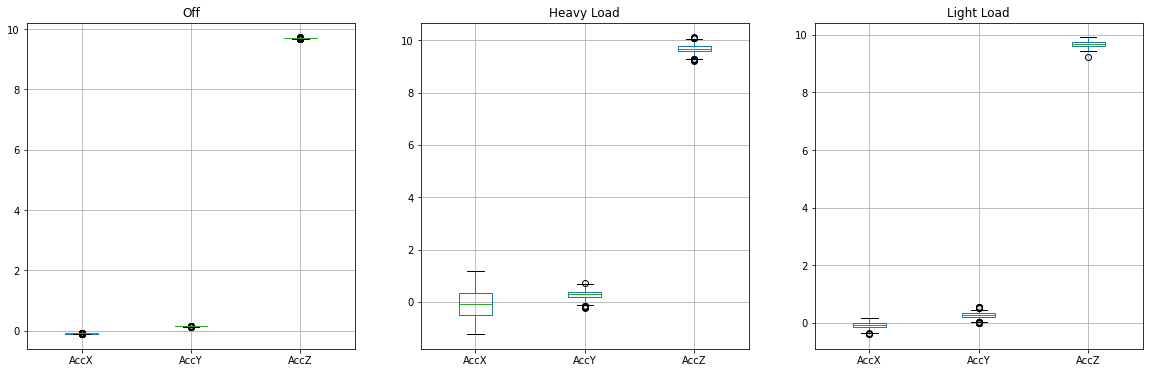

In [7]:
plt.figure(figsize=(20,6));
plt.subplot(1,3,1); df_off_rand_exp.boxplot(); plt.title('Off');
plt.subplot(1,3,2); df_heavy_load_rand_exp.boxplot(); plt.title('Heavy Load');
plt.subplot(1,3,3); df_light_load_rand_exp.boxplot(); plt.title('Light Load');

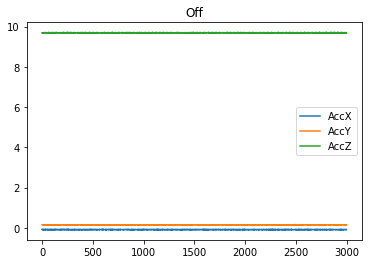

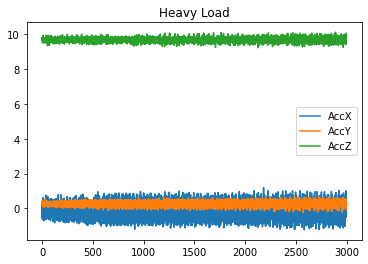

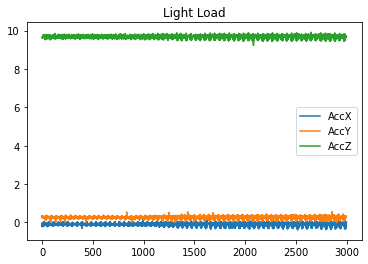

In [8]:
df_off_rand_exp.plot(); plt.title('Off');
df_heavy_load_rand_exp.plot(); plt.title('Heavy Load');
df_light_load_rand_exp.plot(); plt.title('Light Load');

In [9]:
df_off_col_names = {'AccX': 'OffAccX', 'AccY': 'OffAccY', 'AccZ': 'OffAccZ'}
df_heavy_load_col_names = {'AccX': 'HeavyAccX', 'AccY': 'HeavyAccY', 'AccZ': 'HeavyAccZ'}
df_light_load_col_names = {'AccX': 'LightAccX', 'AccY': 'LightAccY', 'AccZ': 'LightAccZ'}

df_off_rand_exp_aux = df_off_rand_exp.rename(df_off_col_names, axis='columns')
df_heavy_load_rand_exp_aux = df_heavy_load_rand_exp.rename(df_heavy_load_col_names, axis='columns')
df_light_load_rand_exp_aux =df_light_load_rand_exp.rename(df_light_load_col_names, axis='columns')

df_descriptions = pd.concat([df_off_rand_exp_aux.describe(), df_heavy_load_rand_exp_aux.describe(), df_light_load_rand_exp_aux.describe()], axis=1)
df_descriptions = df_descriptions[['OffAccX', 'HeavyAccX', 'LightAccX',
                                  'OffAccY', 'HeavyAccY', 'LightAccY',
                                  'OffAccZ', 'HeavyAccZ', 'LightAccZ']]
df_descriptions

,OffAccX,HeavyAccX,LightAccX,OffAccY,HeavyAccY,LightAccY,OffAccZ,HeavyAccZ,LightAccZ
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.090362,-0.084732,-0.087992,0.144475,0.274923,0.263725,9.692958,9.677834,9.667238
std,0.004885,0.522384,0.096101,0.004497,0.153681,0.085098,0.005859,0.142209,0.092345
min,-0.106542,-1.229423,-0.386664,0.131681,-0.241814,0.002394,9.671378,9.221268,9.228451
25%,-0.093374,-0.505177,-0.148441,0.141258,0.173580,0.209193,9.689334,9.582792,9.607931
50%,-0.089783,-0.082600,-0.071826,0.144849,0.288501,0.276530,9.692925,9.679757,9.668385
75%,-0.087388,0.355539,-0.008380,0.147243,0.383072,0.329203,9.696517,9.775525,9.738416
max,-0.071826,1.197101,0.156820,0.160412,0.712275,0.565032,9.718064,10.108319,9.910798


# Differential Investigation

In [10]:
df_off_rand_exp['DiffAccX'] = np.diff(df_off_rand_exp['AccX'], prepend=df_off_rand_exp['AccX'].iloc[0])
df_off_rand_exp['DiffAccY'] = np.diff(df_off_rand_exp['AccY'], prepend=df_off_rand_exp['AccY'].iloc[0])
df_off_rand_exp['DiffAccZ'] = np.diff(df_off_rand_exp['AccZ'], prepend=df_off_rand_exp['AccZ'].iloc[0])

df_heavy_load_rand_exp['DiffAccX'] = np.diff(df_heavy_load_rand_exp['AccX'], prepend=df_heavy_load_rand_exp['AccX'].iloc[0])
df_heavy_load_rand_exp['DiffAccY'] = np.diff(df_heavy_load_rand_exp['AccY'], prepend=df_heavy_load_rand_exp['AccY'].iloc[0])
df_heavy_load_rand_exp['DiffAccZ'] = np.diff(df_heavy_load_rand_exp['AccZ'], prepend=df_heavy_load_rand_exp['AccZ'].iloc[0])

df_light_load_rand_exp['DiffAccX'] = np.diff(df_light_load_rand_exp['AccX'], prepend=df_light_load_rand_exp['AccX'].iloc[0])
df_light_load_rand_exp['DiffAccY'] = np.diff(df_light_load_rand_exp['AccY'], prepend=df_light_load_rand_exp['AccY'].iloc[0])
df_light_load_rand_exp['DiffAccZ'] = np.diff(df_light_load_rand_exp['AccZ'], prepend=df_light_load_rand_exp['AccZ'].iloc[0])


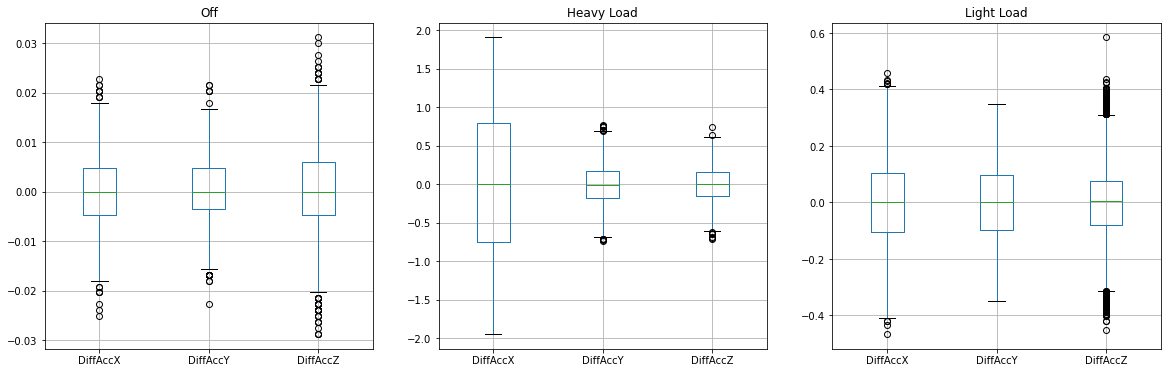

In [11]:
plt.figure(figsize=(20,6));
plt.subplot(1,3,1); df_off_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].boxplot(); plt.title('Off');
plt.subplot(1,3,2); df_heavy_load_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].boxplot(); plt.title('Heavy Load');
plt.subplot(1,3,3); df_light_load_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].boxplot(); plt.title('Light Load');

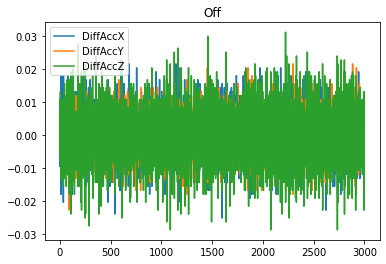

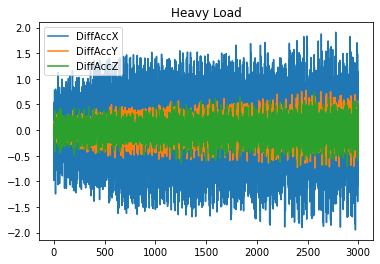

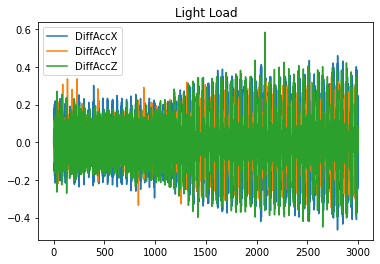

In [12]:
df_off_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].plot(); plt.title('Off');
df_heavy_load_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].plot(); plt.title('Heavy Load');
df_light_load_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].plot(); plt.title('Light Load');

# Defining features and preparing the train/test datasets

In [13]:
# The objectives of this function are:
#   1. To generate a file per experiment in the Curated Layer for traceability
#   2. To generate a single dataframe containing aggregated metrics per experiment (one row per experiment)

def generate_experiments_metrics(df, category):
    experiments = df.ExperimentID.unique()
    experiments_metrics = []

    for experiment in experiments:
        experiment_path = './Data/Curated/' + category + '/' 
        
        if not os.path.exists(experiment_path):
            os.mkdir(experiment_path)

        experiment_file_name = experiment_path + 'Experiment' + str(experiment) + '.csv'

        pd.options.mode.chained_assignment = None # Disable false positive warning
        df_exp = df.loc[df['ExperimentID'] == experiment]

        df_exp.to_csv(experiment_file_name)

        df_exp['DiffAccX'] = np.diff(df_exp['AccX'], prepend=df_exp['AccX'].iloc[0])
        df_exp['DiffAccY'] = np.diff(df_exp['AccY'], prepend=df_exp['AccY'].iloc[0])
        df_exp['DiffAccZ'] = np.diff(df_exp['AccZ'], prepend=df_exp['AccZ'].iloc[0])

        aggregated_metrics = {
            'MeanAccX' : df_exp.AccX.mean(),
            'MedianAccX' : df_exp.AccX.median(), 
            'MaxAccX' : df_exp.AccX.max(),
            'MinAccX' : df_exp.AccX.min(),
            '1stQuartileAccX' : df_exp.AccX.quantile(0.25),
            '2ndQuartileAccX' : df_exp.AccX.quantile(0.50),
            '3rdQuartileAccX' : df_exp.AccX.quantile(0.75),
            'DeltaMinMaxAccX' : df_exp.AccX.max() - df_exp.AccX.min(),
            'StdDevAccX' : df_exp.AccX.std(),
            'MeanDiffAccX' : df_exp.DiffAccX.mean(),
            'MedianDiffAccX' : df_exp.DiffAccX.median(), 
            'MaxDiffAccX' : df_exp.DiffAccX.max(),
            'MinDiffAccX' : df_exp.DiffAccX.min(),
            '1stQuartileDiffAccX' : df_exp.DiffAccX.quantile(0.25),
            '2ndQuartileDiffAccX' : df_exp.DiffAccX.quantile(0.50),
            '3rdQuartileDiffAccX' : df_exp.DiffAccX.quantile(0.75),
            'DeltaMinMaxDiffAccX' : df_exp.DiffAccX.max() - df_exp.DiffAccX.min(),
            'StdDevDiffAccX' : df_exp.DiffAccX.std(),

            'MeanAccY' : df_exp.AccY.mean(),
            'MedianAccY' : df_exp.AccY.median(), 
            'MaxAccY' : df_exp.AccY.max(),
            'MinAccY' : df_exp.AccY.min(),
            '1stQuartileAccY' : df_exp.AccY.quantile(0.25),
            '2ndQuartileAccY' : df_exp.AccY.quantile(0.50),
            '3rdQuartileAccY' : df_exp.AccY.quantile(0.75),
            'DeltaMinMaxAccY' : df_exp.AccY.max() - df_exp.AccY.min(),
            'StdDevAccY' : df_exp.AccY.std(),
            'MeanDiffAccY' : df_exp.DiffAccY.mean(),
            'MedianDiffAccY' : df_exp.DiffAccY.median(), 
            'MaxDiffAccY' : df_exp.DiffAccY.max(),
            'MinDiffAccY' : df_exp.DiffAccY.min(),
            '1stQuartileDiffAccY' : df_exp.DiffAccY.quantile(0.25),
            '2ndQuartileDiffAccY' : df_exp.DiffAccY.quantile(0.50),
            '3rdQuartileDiffAccY' : df_exp.DiffAccY.quantile(0.75),
            'DeltaMinMaxDiffAccY' : df_exp.DiffAccY.max() - df_exp.DiffAccY.min(),
            'StdDevDiffAccY' : df_exp.DiffAccY.std(),

            'MeanAccZ' : df_exp.AccZ.mean(),
            'MedianAccZ' : df_exp.AccZ.median(), 
            'MaxAccZ' : df_exp.AccZ.max(),
            'MinAccZ' : df_exp.AccZ.min(),
            '1stQuartileAccZ' : df_exp.AccZ.quantile(0.25),
            '2ndQuartileAccZ' : df_exp.AccZ.quantile(0.50),
            '3rdQuartileAccZ' : df_exp.AccZ.quantile(0.75),
            'DeltaMinMaxAccZ' : df_exp.AccZ.max() - df_exp.AccZ.min(),
            'StdDevAccZ' : df_exp.AccZ.std(),
            'MeanDiffAccZ' : df_exp.DiffAccZ.mean(),
            'MedianDiffAccZ' : df_exp.DiffAccZ.median(), 
            'MaxDiffAccZ' : df_exp.DiffAccZ.max(),
            'MinDiffAccZ' : df_exp.DiffAccZ.min(),
            '1stQuartileDiffAccZ' : df_exp.DiffAccZ.quantile(0.25),
            '2ndQuartileDiffAccZ' : df_exp.DiffAccZ.quantile(0.50),
            '3rdQuartileDiffAccZ' : df_exp.DiffAccZ.quantile(0.75),
            'DeltaMinMaxDiffAccZ' : df_exp.DiffAccZ.max() - df_exp.DiffAccZ.min(),
            'StdDevDiffAccZ' : df_exp.DiffAccZ.std(),

            'Category' : category,
            'SourceFile' : experiment_file_name 
        }

        experiments_metrics.append(aggregated_metrics)

    return pd.DataFrame(experiments_metrics)

In [14]:
df_off_aggr = generate_experiments_metrics(df_off, 'Off')
df_heavy_load_aggr = generate_experiments_metrics(df_heavy_load, 'HeavyLoad')
df_light_load_aggr = generate_experiments_metrics(df_light_load, 'LightLoad')

In [15]:
# Preview of the dataset with aggregated values
df_off_aggr.head()

,MeanAccX,MedianAccX,MaxAccX,MinAccX,1stQuartileAccX,2ndQuartileAccX,3rdQuartileAccX,DeltaMinMaxAccX,StdDevAccX,MeanDiffAccX,...,MedianDiffAccZ,MaxDiffAccZ,MinDiffAccZ,1stQuartileDiffAccZ,2ndQuartileDiffAccZ,3rdQuartileDiffAccZ,DeltaMinMaxDiffAccZ,StdDevDiffAccZ,Category,SourceFile
0,-0.090362,-0.089783,-0.071826,-0.106542,-0.093374,-0.089783,-0.087388,0.034716,0.004885,-4.788401e-06,...,0.0,0.031125,-0.028730,-0.004788,0.0,0.005985,0.059855,0.008328,Off,./Data/Curated/Off/Experiment1.csv
1,-0.090549,-0.090980,-0.074220,-0.106542,-0.093374,-0.090980,-0.087388,0.032322,0.004771,-4.389370e-06,...,0.0,0.029927,-0.029927,-0.004788,0.0,0.004788,0.059855,0.008028,Off,./Data/Curated/Off/Experiment2.csv
2,-0.089923,-0.089783,-0.067038,-0.110133,-0.093374,-0.089783,-0.086191,0.043096,0.004939,3.990357e-07,...,0.0,0.029927,-0.029927,-0.004788,0.0,0.004788,0.059855,0.008254,Off,./Data/Curated/Off/Experiment3.csv
3,-0.090444,-0.090980,-0.074220,-0.106542,-0.093374,-0.090980,-0.087388,0.032322,0.004970,0.000000e+00,...,0.0,0.046687,-0.031124,-0.004788,0.0,0.004788,0.077811,0.008423,Off,./Data/Curated/Off/Experiment4.csv
4,-0.089865,-0.089783,-0.073023,-0.106542,-0.093374,-0.089783,-0.086191,0.033519,0.005088,1.596133e-06,...,0.0,0.039504,-0.050279,-0.005985,0.0,0.005985,0.089783,0.009522,Off,./Data/Curated/Off/Experiment5.csv


In [16]:
# Generating a single dataframe that will be split into train and test
df_full = pd.concat([df_off_aggr, df_heavy_load_aggr, df_light_load_aggr], ignore_index=True)

In [36]:
# Splitting the data into train and test

X = df_full.drop('Category', axis='columns')
y = df_full['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [37]:
# Generating train and test files

train_test_path = './Data/Analytics/'

df_train = X_train.copy()
df_train['Category'] = y_train

df_test = X_test.copy()
df_test['Category'] = y_test

if not os.path.exists(train_test_path):
    os.mkdir(train_test_path)

df_train.to_csv(train_test_path + 'Train.csv')
df_test.to_csv(train_test_path + 'Test.csv')

In [38]:
try:
    X_train.drop('SourceFile', axis='columns', inplace=True)
    X_test.drop('SourceFile', axis='columns', inplace=True)
except:
    print('SourceFile column already removed')

In [39]:
X_train.head()

,MeanAccX,MedianAccX,MaxAccX,MinAccX,1stQuartileAccX,2ndQuartileAccX,3rdQuartileAccX,DeltaMinMaxAccX,StdDevAccX,MeanDiffAccX,...,StdDevAccZ,MeanDiffAccZ,MedianDiffAccZ,MaxDiffAccZ,MinDiffAccZ,1stQuartileDiffAccZ,2ndQuartileDiffAccZ,3rdQuartileDiffAccZ,DeltaMinMaxDiffAccZ,StdDevDiffAccZ
15,-0.084084,-0.130484,0.866701,-0.986411,-0.442927,-0.130484,0.294786,1.853112,0.427350,-0.000124,...,0.228850,0.000074,0.022745,0.712276,-0.879869,-0.222660,0.022745,0.238223,1.592145,0.311806
10,-0.086767,-0.076614,0.804452,-1.058237,-0.391452,-0.076614,0.226252,1.862689,0.411348,-0.000202,...,0.175291,-0.000094,-0.011971,0.618901,-0.703895,-0.185551,-0.011971,0.204704,1.322796,0.255613
4,-0.089865,-0.089783,-0.073023,-0.106542,-0.093374,-0.089783,-0.086191,0.033519,0.005088,0.000002,...,0.006503,-0.000004,0.000000,0.039504,-0.050279,-0.005985,0.000000,0.005985,0.089783,0.009522
13,-0.080933,-0.070629,0.797269,-0.940921,-0.347459,-0.070629,0.144849,1.738190,0.358030,-0.000232,...,0.171680,-0.000063,0.003591,0.584186,-0.604535,-0.175974,0.003591,0.185551,1.188721,0.241042
22,-0.087007,-0.087987,0.891840,-1.107318,-0.495600,-0.087987,0.316035,1.999158,0.479786,0.000011,...,0.129457,0.000016,0.004788,0.460883,-0.548273,-0.119710,0.004788,0.131981,1.009156,0.181664


# Selecting features and applying Machine Learning

Training dataset score: 1.0
Test dataset score: 0.8


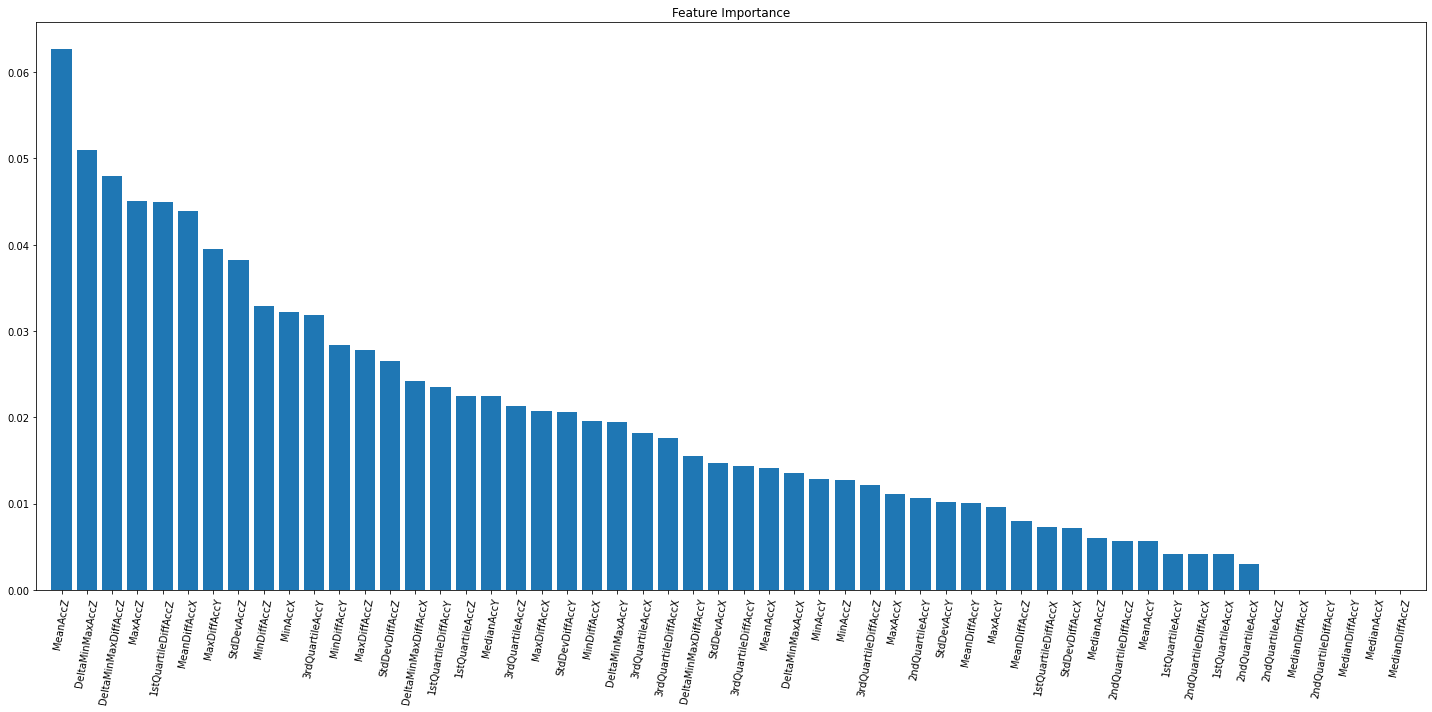


Features importance: 

 1) MeanAccZ                       0.062635
 2) DeltaMinMaxAccZ                0.050950
 3) DeltaMinMaxDiffAccZ            0.047982
 4) MaxAccZ                        0.045066
 5) 1stQuartileDiffAccZ            0.044975
 6) MeanDiffAccX                   0.043923
 7) MaxDiffAccY                    0.039547
 8) StdDevAccZ                     0.038222
 9) MinDiffAccZ                    0.032884
10) MinAccX                        0.032200
11) 3rdQuartileAccY                0.031840
12) MinDiffAccY                    0.028405
13) MaxDiffAccZ                    0.027787
14) StdDevDiffAccZ                 0.026517
15) DeltaMinMaxDiffAccX            0.024199
16) 1stQuartileDiffAccY            0.023471
17) 1stQuartileAccZ                0.022438
18) MedianAccY                     0.022419
19) 3rdQuartileAccZ                0.021349
20) MaxDiffAccX                    0.020730
21) StdDevDiffAccY                 0.020576
22) MinDiffAccX                    0.019632
23) Delt

In [40]:
# Using a RandomForestClassifier to assess feature importance

# Fitting the model
# Random Forests do not require scaling
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

print("Training dataset score:", forest.score(X_train, y_train))
print("Test dataset score:", forest.score(X_test, y_test))

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

feat_labels = X_train.columns

plt.figure(figsize=(20,10))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=80)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

print("\nFeatures importance: \n")
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

In [46]:
# Limiting the number of features being used with SelectFromModel

# Setting a threshold of 1% for feature importance based in our forest model
sfm = SelectFromModel(forest, threshold=0.01, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet the threshold criterion:', 
      X_selected.shape[1])
print('Feature names: ')
selected_columns = []
for f in range(X_selected.shape[1]):
      print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
      selected_columns.append(feat_labels[indices[f]])

Number of features that meet the threshold criterion: 37
Feature names: 
 1) MeanAccZ                       0.062635
 2) DeltaMinMaxAccZ                0.050950
 3) DeltaMinMaxDiffAccZ            0.047982
 4) MaxAccZ                        0.045066
 5) 1stQuartileDiffAccZ            0.044975
 6) MeanDiffAccX                   0.043923
 7) MaxDiffAccY                    0.039547
 8) StdDevAccZ                     0.038222
 9) MinDiffAccZ                    0.032884
10) MinAccX                        0.032200
11) 3rdQuartileAccY                0.031840
12) MinDiffAccY                    0.028405
13) MaxDiffAccZ                    0.027787
14) StdDevDiffAccZ                 0.026517
15) DeltaMinMaxDiffAccX            0.024199
16) 1stQuartileDiffAccY            0.023471
17) 1stQuartileAccZ                0.022438
18) MedianAccY                     0.022419
19) 3rdQuartileAccZ                0.021349
20) MaxDiffAccX                    0.020730
21) StdDevDiffAccY                 0.020576
22)

In [47]:
X_train_refined = pd.DataFrame(X_selected, columns=selected_columns)
X_test_refined = X_test[selected_columns]

In [48]:
# Using SVM to classify the data based in the most relevant features

stdsc = StandardScaler()
X_train_refined_std = stdsc.fit_transform(X_train_refined)
X_test_refined_std = stdsc.fit_transform(X_test_refined)

svc = svm.SVC()
svc.fit(X_train_refined_std, y_train)

print("Training dataset score:", svc.score(X_train_refined_std, y_train))
print("Test dataset score:", svc.score(X_test_refined_std, y_test))

Training dataset score: 1.0
Test dataset score: 0.6


In [49]:
# Writing the forecasted values to a dedicated file

forecast_analytics_file_name = './Data/Analytics/forecast.csv'

y_pred = svc.predict(X_test_refined_std)

df_pred = X_test.copy()
df_pred['ActualCategory'] = y_test
df_pred['ForecastedCategory'] = y_pred
df_pred['SourceFile'] = df_test['SourceFile']

df_pred.to_csv(forecast_analytics_file_name, index=False)

print("Test Dataset Forecasted")
df_pred.head()

Test Dataset Forecasted


,MeanAccX,MedianAccX,MaxAccX,MinAccX,1stQuartileAccX,2ndQuartileAccX,3rdQuartileAccX,DeltaMinMaxAccX,StdDevAccX,MeanDiffAccX,...,MaxDiffAccZ,MinDiffAccZ,1stQuartileDiffAccZ,2ndQuartileDiffAccZ,3rdQuartileDiffAccZ,DeltaMinMaxDiffAccZ,StdDevDiffAccZ,ActualCategory,ForecastedCategory,SourceFile
9,-0.083937,-0.088585,1.466449,-1.628057,-0.623690,-0.088585,0.442029,3.094506,0.664514,-0.000123,...,0.967257,-0.968455,-0.227449,0.007182,0.240618,1.935713,0.329713,HeavyLoad,LightLoad,./Data/Curated/HeavyLoad/Experiment2.csv
21,-0.086145,-0.075417,1.328782,-1.399411,-0.530316,-0.075417,0.355539,2.728193,0.579926,0.000231,...,0.611719,-0.842759,-0.136769,0.017956,0.147243,1.454478,0.210667,LightLoad,LightLoad,./Data/Curated/LightLoad/Experiment6.csv
20,-0.086517,-0.095768,0.520739,-0.733823,-0.207398,-0.095768,0.017957,1.254562,0.189422,-0.000036,...,0.463278,-0.495600,-0.092177,0.000000,0.093374,0.958878,0.152363,LightLoad,LightLoad,./Data/Curated/LightLoad/Experiment5.csv
14,-0.081849,-0.116119,0.842759,-1.036689,-0.432153,-0.116119,0.284012,1.879448,0.434324,0.000322,...,0.715866,-0.822409,-0.205901,0.004788,0.216675,1.538275,0.286985,HeavyLoad,LightLoad,./Data/Curated/HeavyLoad/Experiment7.csv
16,-0.087992,-0.071826,0.156820,-0.386664,-0.148441,-0.071826,-0.008380,0.543484,0.096101,0.000076,...,0.584185,-0.450110,-0.079009,0.003591,0.076614,1.034295,0.144480,LightLoad,LightLoad,./Data/Curated/LightLoad/Experiment1.csv
